# D(St)reams of Anomalies

a project for EECS 731 by Benjamin Wyss

Examining New York City taxi passenger quantities to detect anomalies in the total number of passengers per thirty minute interval.

###### python imports

In [163]:
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import sklearn as skl
import matplotlib.pyplot as plt
plt.close('all')
import warnings
warnings.filterwarnings('ignore')

### Reading Data Set From CSV

Numenta Anomaly Benchmark (NAB) Datasets - Real Known Cause Anomalies - NYC Taxi Dataset

Taken from: https://github.com/numenta/NAB/tree/master/data on 10/15/20

This data set was selected to be examined for the following reasons:

(1): It has a great total number of samples (10,320).
(2): Out of all of the NAB datasets, it contains the most labeled anomalies (5).
(3): Because it contains real data with real known anomaly causes, it will be easier to reason about.

###### NYC taxi passenger quantities per thirty minute interval

In [164]:
df = pd.read_csv('../data/raw/nyc_taxi.csv')

In [165]:
df

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


## The Big Ideas

Feature engineering and transformation can add value to this data set for constructing an anomaly detection model in the following ways:

(1): By extracting new features from the timestamp attribute such as isMajorHoliday, isNight, and isWeekend, an anomaly detection model can look for anomalies relative to different subsets of data points.

(2): By standardizing timestamp hours and minutes to a value between 0 and 1, anomaly detection models can reason about taxi passenger quantity by time of day without being overinfluenced by the large magnitudes of hours and minutes.

(3): By excluding unimportant timestamp attributes--such as day, month, and year--from being anomaly detection model features, model accuracy will improve because these attributes provide little information as far as anomalous behavior is concerned.

## Exploratory Data Analysis

### Cleaning the Data Set

First, the timestamp column is converted to the pandas datetime type so that it can later be reasoned about component-wise

In [166]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [167]:
df

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820
...,...,...
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591


Next, the samples which are indicated as anomalies according to https://github.com/numenta/NAB/blob/master/labels/combined_labels.json are labeled as such.

As stated in https://github.com/numenta/NAB/tree/master/data, the five labeled anomalies correspond to the NYC marathon, Thanksgiving, Christmas, New Year's day, and the January 27 Blizzard of 2015. 

In [168]:
df['isAnomaly'] = 0
df.loc[df.timestamp == '2014-11-01 19:00:00', 'isAnomaly'] = 1
df.loc[df.timestamp == '2014-11-27 15:30:00', 'isAnomaly'] = 1
df.loc[df.timestamp == '2014-12-25 15:00:00', 'isAnomaly'] = 1
df.loc[df.timestamp == '2015-01-01 01:00:00', 'isAnomaly'] = 1
df.loc[df.timestamp == '2015-01-27 00:00:00', 'isAnomaly'] = 1

In [169]:
df[df.isAnomaly == 1]

,timestamp,value,isAnomaly
5942,2014-11-01 19:00:00,28398,1
7183,2014-11-27 15:30:00,15255,1
8526,2014-12-25 15:00:00,12039,1
8834,2015-01-01 01:00:00,30236,1
10080,2015-01-27 00:00:00,109,1


In [170]:
df

,timestamp,value,isAnomaly
0,2014-07-01 00:00:00,10844,0
1,2014-07-01 00:30:00,8127,0
2,2014-07-01 01:00:00,6210,0
3,2014-07-01 01:30:00,4656,0
4,2014-07-01 02:00:00,3820,0
...,...,...,...
10315,2015-01-31 21:30:00,24670,0
10316,2015-01-31 22:00:00,25721,0
10317,2015-01-31 22:30:00,27309,0
10318,2015-01-31 23:00:00,26591,0


### Transforming the Data Set

##### Feature Extraction

Using the timestamp column, additional features will be generated to record whether a sample corresponds to nighttime, a weekend, and/or a major U.S. Federal holiday.

The below calculations assume that:

nighttime is between the hours of 7:00 p.m. and 5:00 a.m., 
only Saturday and Sunday count as weekends, 
and major U.S. Federal holidays correspond to holidays listed within the pandas.tseries.holiday USFederalHolidayCalendar.

In [171]:
df['isNight'] = ((df.timestamp.dt.hour >= 19) | (df.timestamp.dt.hour < 5)).astype(int)
df['isWeekend'] = (df.timestamp.dt.dayofweek >= 5).astype(int)

holidays = calendar().holidays(start=df.timestamp.min(), end=df.timestamp.max())
df['isMajorHoliday'] = df['timestamp'].dt.date.astype('datetime64').isin(holidays).astype(int)

In [172]:
df

,timestamp,value,isAnomaly,isNight,isWeekend,isMajorHoliday
0,2014-07-01 00:00:00,10844,0,1,0,0
1,2014-07-01 00:30:00,8127,0,1,0,0
2,2014-07-01 01:00:00,6210,0,1,0,0
3,2014-07-01 01:30:00,4656,0,1,0,0
4,2014-07-01 02:00:00,3820,0,1,0,0
...,...,...,...,...,...,...
10315,2015-01-31 21:30:00,24670,0,1,1,0
10316,2015-01-31 22:00:00,25721,0,1,1,0
10317,2015-01-31 22:30:00,27309,0,1,1,0
10318,2015-01-31 23:00:00,26591,0,1,1,0


### Exporting Transformed Data Set to CSV

In [173]:
df.to_csv('../data/processed/nyc_taxi_transformed.csv')

### Visualizing the Data

First, some basic statistics of the data set and correlation coefficients are calculated. 

In [174]:
df.describe()

,value,isAnomaly,isNight,isWeekend,isMajorHoliday
count,10320.000000,10320.000000,10320.000000,10320.000000,10320.000000
mean,15137.569380,0.000484,0.416667,0.283721,0.037209
std,6939.495808,0.022007,0.493031,0.450825,0.189283
min,8.000000,0.000000,0.000000,0.000000,0.000000
25%,10262.000000,0.000000,0.000000,0.000000,0.000000
50%,16778.000000,0.000000,0.000000,0.000000,0.000000
75%,19838.750000,0.000000,1.000000,1.000000,0.000000
max,39197.000000,1.000000,1.000000,1.000000,1.000000


In [175]:
df.corr()

,value,isAnomaly,isNight,isWeekend,isMajorHoliday
value,1.000000,0.006567,-2.918272e-02,6.887050e-02,-9.009660e-02
isAnomaly,0.006567,1.000000,8.187269e-03,-4.088816e-03,6.546446e-02
isNight,-0.029183,0.008187,1.000000e+00,5.992549e-17,-1.694021e-17
isWeekend,0.068871,-0.004089,5.992549e-17,1.000000e+00,-1.237270e-01
isMajorHoliday,-0.090097,0.065464,-1.694021e-17,-1.237270e-01,1.000000e+00


###### Generating Interesting Plots

<AxesSubplot:title={'center':'Total NYC Taxi Passenger Counts per Thirty Minutes vs. Timestamp'}, xlabel='timestamp'>

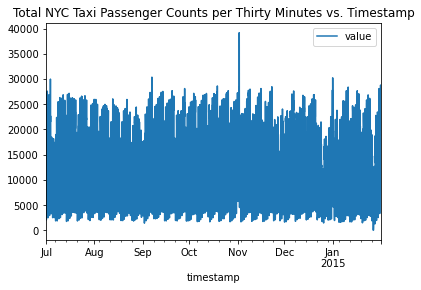

In [176]:
df.plot(x='timestamp', y='value', title='Total NYC Taxi Passenger Counts per Thirty Minutes vs. Timestamp')

There is so much data that this graph is cluttered. Now, examine just one week's worth of data to see the general daily trend.

<AxesSubplot:title={'center':'One Week of Total NYC Taxi Passenger Counts per Thirty Minutes vs. Timestamp'}, xlabel='timestamp'>

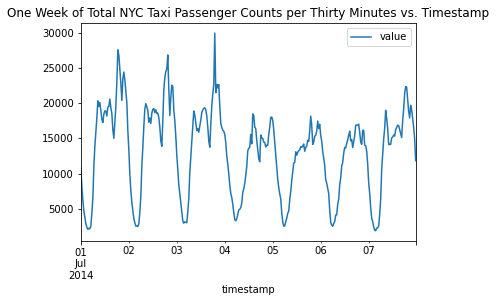

In [177]:
df.head(24*2*7).plot(x='timestamp', y='value', title='One Week of Total NYC Taxi Passenger Counts per Thirty Minutes vs. Timestamp')

Now, examine the data for each day where an anomaly occurs

<AxesSubplot:title={'center':'NYC Marathon Anomaly Occuring at 19:00 Hours'}, xlabel='timestamp'>

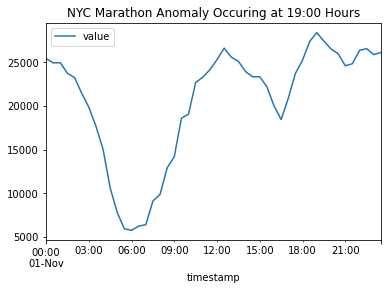

In [178]:
df[df.timestamp.dt.date == pd.Timestamp('2014-11-01')].plot(x='timestamp', y='value', title='NYC Marathon Anomaly Occuring at 19:00 Hours')

<AxesSubplot:title={'center':'Thanksgiving Anomaly Occuring at 15:30 Hours'}, xlabel='timestamp'>

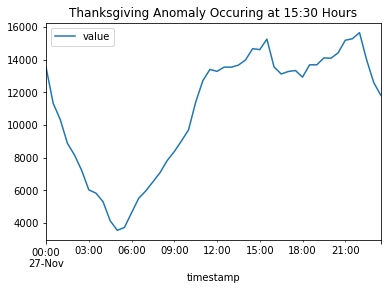

In [179]:
df[df.timestamp.dt.date == pd.Timestamp('2014-11-27')].plot(x='timestamp', y='value', title='Thanksgiving Anomaly Occuring at 15:30 Hours')

<AxesSubplot:title={'center':'Christmas Anomaly Occuring at 15:00Hours'}, xlabel='timestamp'>

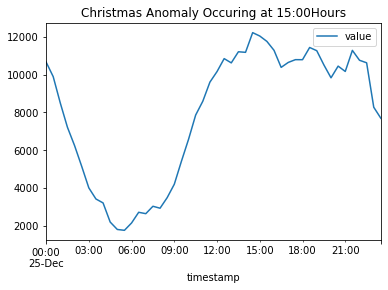

In [180]:
df[df.timestamp.dt.date == pd.Timestamp('2014-12-25')].plot(x='timestamp', y='value', title='Christmas Anomaly Occuring at 15:00Hours')

<AxesSubplot:title={'center':"New Year's Day Anomaly Occuring at 01:00 Hours"}, xlabel='timestamp'>

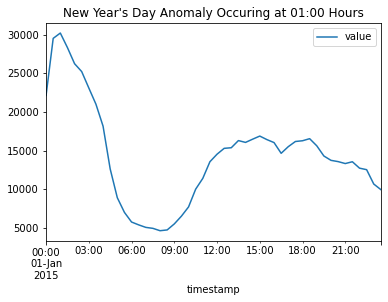

In [181]:
df[df.timestamp.dt.date == pd.Timestamp('2015-01-01')].plot(x='timestamp', y='value', title='New Year\'s Day Anomaly Occuring at 01:00 Hours')

<AxesSubplot:title={'center':'Blizzard Anomaly Occuring at 00:00 Hours'}, xlabel='timestamp'>

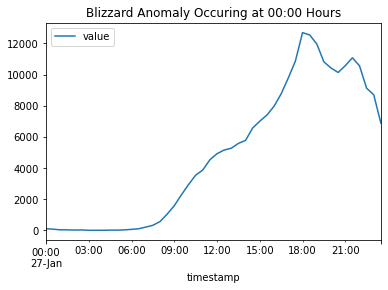

In [182]:
df[df.timestamp.dt.date == pd.Timestamp('2015-01-27')].plot(x='timestamp', y='value', title='Blizzard Anomaly Occuring at 00:00 Hours')

### Model Construction

### Testing Different Models

## Results